In [631]:
import collections
from operator import itemgetter
import re
import nltk
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
from nltk.corpus import stopwords                                  
from itertools import permutations
import matplotlib.pyplot as plt
import cvxpy as cp
import networkx as nx
import scipy.linalg as la
from scipy.optimize import minimize
import requests
from bs4 import BeautifulSoup
import time
from  sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /home/dell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [632]:
url = 'https://www.gutenberg.org/files/205/205-h/205-h.htm'

## Getting text from the book using the url

In [633]:
def get_text(url):
    r = requests.get(url)
    html = r.text
    soup = BeautifulSoup(html)
    text = soup.get_text()
    return text

In [634]:
text_content = get_text(url)

In [635]:
text_content

'ï»¿\n\n\n\n\nWalden, by Henry David Thoreau\n\r\n\r\nbody { background:#faebd0;\r\n       margin-right: 15%;\r\n       margin-left: 15%;\r\n       font-family: "Times New Roman", serif;\r\n       text-align: justify }\r\n\r\np {text-indent: 1em;\r\n   margin-top: 0.25em;\r\n   margin-bottom: 0.25em; }\r\n\r\nh1, h2, h3, h4, h5, h6 {text-align: center; font-style: normal;\r\nfont-weight: normal; line-height: 1.5; margin-top: .5em; margin-bottom:\r\n.5em;}\r\n\r\nh1 {font-size: 300%;\r\n    margin-top: 0.6em;\r\n    margin-bottom: 0.6em;\r\n    letter-spacing: 0.12em;\r\n    word-spacing: 0.2em;\r\n    text-indent: 0em;}\r\nh2 {font-size: 175%;}\r\nh3 {font-size: 150%;}\r\nh4 {font-size: 120%;}\r\nh5 {font-size: 110%;}\r\n\r\np.poem {text-indent: 0%;\r\n        margin-left: 10%;\r\n        font-size: 90%;\r\n        margin-top: 1em;\r\n        margin-bottom: 1em; }\r\n\r\np.noindent {text-indent: 0% }\r\n\r\na:link {color:blue; text-decoration:none}\r\na:visited {color:blue; text-decora

## Tokenize by sentences and deleting garbage sentences

In [636]:
sentences = sent_tokenize(text_content)
del sentences[0:4]

## Tokenize each sentence by words, convert all to lower case,
## remove punctuation and remove stop words

In [637]:
def clean_sentences(sentences):
    tokens = []
    
    for sentence in sentences:
        token = word_tokenize(sentence)
        token = [w.lower() for w in token]
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in token]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        tokens.append(words)

    return tokens

In [638]:
sentences = clean_sentences(sentences)

In [639]:
sentences[0]

['obtrude',
 'affairs',
 'much',
 'notice',
 'readers',
 'particular',
 'inquiries',
 'made',
 'townsmen',
 'concerning',
 'mode',
 'life',
 'would',
 'call',
 'impertinent',
 'though',
 'appear',
 'impertinent',
 'considering',
 'circumstances',
 'natural',
 'pertinent']

## Get graph vertices and auxiliar objects

In [640]:
def get_vertices(sentences):
    graph_vertices = []
    inverse_words = []
    for sentence in sentences:
        sentence_set = set(sentence)
        vertex = {}
        inverse = {}
        for index, word in enumerate(sentence_set):
            vertex[word] = index
            inverse[index] = word
        graph_vertices.append(vertex)
        inverse_words.append(inverse)
    return graph_vertices, inverse_words

In [641]:
graph_vertices, inverse_words = get_vertices(sentences)

In [642]:
graph_vertices[0]

{'particular': 0,
 'readers': 1,
 'inquiries': 2,
 'considering': 3,
 'impertinent': 4,
 'obtrude': 5,
 'made': 6,
 'concerning': 7,
 'townsmen': 8,
 'notice': 9,
 'though': 10,
 'mode': 11,
 'circumstances': 12,
 'affairs': 13,
 'would': 14,
 'appear': 15,
 'much': 16,
 'natural': 17,
 'pertinent': 18,
 'life': 19,
 'call': 20}

In [643]:
inverse_words[0]

{0: 'particular',
 1: 'readers',
 2: 'inquiries',
 3: 'considering',
 4: 'impertinent',
 5: 'obtrude',
 6: 'made',
 7: 'concerning',
 8: 'townsmen',
 9: 'notice',
 10: 'though',
 11: 'mode',
 12: 'circumstances',
 13: 'affairs',
 14: 'would',
 15: 'appear',
 16: 'much',
 17: 'natural',
 18: 'pertinent',
 19: 'life',
 20: 'call'}

## Getting words set for each sentence
## And also a global set with all words
## It's useful to find the word vectors efficiently

In [644]:
def get_words_list(graph_vertices):
    words_list = []
    for i in range(len(graph_vertices)):
        words_set = set()
        for key in graph_vertices[i]:
            words_set.add(key)
        words_list.append(words_set)
    return words_list

In [645]:
words_list = get_words_list(graph_vertices)

In [646]:
def get_words_set(graph_vertices):
    words_set = set()
    for i in range(len(graph_vertices)):
        for key in graph_vertices[i]:
            words_set.add(key)
    return words_set

In [647]:
words_set = get_words_set(graph_vertices)

In [648]:
len(words_set)

11352

## Getting the decoded sentences

In [649]:
def get_decoded_sentences(graph_vertices, sentences):
    decoded_sentences = []
    count = 0
    for vertex in graph_vertices:
        decoded_sentence = [vertex[word] for word in sentences[count]]
        decoded_sentences.append(decoded_sentence)
        count += 1
    return decoded_sentences

In [650]:
decoded_sentences = get_decoded_sentences(graph_vertices, sentences)

In [651]:
decoded_sentences[0]

[5, 13, 16, 9, 1, 0, 2, 6, 8, 7, 11, 19, 14, 20, 4, 10, 15, 4, 3, 12, 17, 18]

In [652]:
len(decoded_sentences)

4016

## Getting the adjacency matrix for each sentence

In [653]:
def get_adj_mats(decoded_sentences, window_size):
    adj_mats = []
    for decoded_sentence in decoded_sentences:
        adj_mat = np.zeros([len(set(decoded_sentence)), len(set(decoded_sentence))])
        
        for i in range(len(decoded_sentences)-window_size+1):
            n_gram = decoded_sentence[i:i+window_size]
            n_gram_set = set(n_gram)
            reps = dict()
            
            for needle in n_gram_set:
                reps[needle] = 0
                for word in n_gram:
                    if word == needle:
                        reps[needle] += 1
                        
            n_gram = list(n_gram_set)
            
            for j in range(len(n_gram)):
                for z in range(j+1, len(n_gram)):
                    adj_mat[n_gram[j]][n_gram[z]] += reps[n_gram[j]]*reps[n_gram[z]]
                    adj_mat[n_gram[z]][n_gram[j]] += reps[n_gram[j]]*reps[n_gram[z]]
        
        adj_mats.append(adj_mat)
    
    return adj_mats

In [654]:
adj_mats = get_adj_mats(decoded_sentences, 3)

## Getting non-zero percentage and median non-zero percentage in adjacency matrices

In [655]:
def non_zero_percentage(adj_mat):
    count = 0
    for i in range(len(adj_mat)):
        for j in range(len(adj_mat)):
            if adj_mat[i][j] != 0:
                count += 1
    if len(adj_mat) != 0:
        return count/(len(adj_mat)**2)
    else:
        return 0

In [656]:
def median_non_zero_percentage(adj_mats):
    perc = 0.0
    for i in range(len(adj_mats)):
        perc += non_zero_percentage(adj_mats[i])
    return perc/len(adj_mats)

In [657]:
median_non_zero_percentage(adj_mats)

0.34635831797005273

## Checking that all matrices are symmetric

In [658]:
def check_symmetric(adj_mat, rtol=1e-05, atol=1e-08):
    return np.allclose(adj_mat, adj_mat.T, rtol=rtol, atol=atol)

In [659]:
def all_symmetric(adj_mats):
    for i in range(len(adj_mats)):
        if not check_symmetric(adj_mats[i]):
            return False
    return True

In [660]:
all_symmetric(adj_mats)

True

## Getting edges corresponding to each adjacency matrix

In [661]:
def get_edges(adj_mats):
    edges_sets = []
    for i in range(len(adj_mats)):
        edges = []
        for j in range(len(adj_mats[i])):
            for z in range(j):
                if adj_mats[i][j][z] != 0:
                    edges.append((j,z))
        edges_sets.append(edges)
    return edges_sets

In [662]:
edges_sets = get_edges(adj_mats)

## Getting degree's contribution for each graph of words

In [663]:
def get_degree_contributions(adj_mats, edges_sets):
    degree_contributions = []
    for i in range(len(edges_sets)):
        degree = dict()
        for edge in edges_sets[i]:
            degree[edge[0]] = 0
            degree[edge[1]] = 0
        for edge in edges_sets[i]:
            degree[edge[0]] += 1
            degree[edge[1]] += 1
        vertices_set = set()
        for edge in edges_sets[i]:
            vertices_set.add(edge[0])
            vertices_set.add(edge[1])
        for vertex in vertices_set:
            degree[vertex] /= 2*len(edges_sets[i])
        degree_contributions.append(degree)
    return degree_contributions

In [664]:
degree_contributions = get_degree_contributions(adj_mats, edges_sets)

## Getting the function that we want to optimize in the SDP for each graph of words
## in the format of matrices

In [665]:
def get_C(edges, size_adj_mat):
    C = np.zeros([size_adj_mat, size_adj_mat])
    for edge in edges:
        C[edge[0]][edge[0]] += 1
        C[edge[1]][edge[1]] += 1
        C[edge[0]][edge[1]] -= 1
        C[edge[1]][edge[0]] -= 1
    return C

In [666]:
def get_Cs(edges_sets, adj_mats):
    C_list = []
    for i in range(len(edges_sets)):
        C_list.append(get_C(edges_sets[i], len(adj_mats[i])))
    return C_list

In [667]:
C_list = get_Cs(edges_sets, adj_mats)

## Getting the constraints for each SDP corresponding to a graph of words
## in the format of a matrices

In [668]:
def get_constraints(edges, adj_mat):
    A = []
    b = []
    count = 0
    
    for edge in edges:
        A.append(np.zeros([len(adj_mat), len(adj_mat)]))
        A[count][edge[0]][edge[0]] += 1
        A[count][edge[1]][edge[1]] += 1
        A[count][edge[0]][edge[1]] -= 1
        A[count][edge[1]][edge[0]] -= 1
        b.append(adj_mat[edge[0]][edge[1]]**2)
        count += 1
    
    return (A, b)

In [669]:
def get_all_constraints(edges_sets, adj_mats):
    A_list = []
    b_list = []
    for i in range(len(edges_sets)):
        A, b = get_constraints(edges_sets[i], adj_mats[i])
        A_list.append(A)
        b_list.append(b)
    return (A_list, b_list)

In [670]:
A_list, b_list = get_all_constraints(edges_sets, adj_mats)

## Solving the SDPs for each graph of words

In [671]:
def solve_SDP(C, A, b, size_adj_mat, size_edges):
    n = size_adj_mat
    p = size_edges
    if n == 0:
        return (0, np.zeros([0,0]))
    else:
        X = cp.Variable((n,n), symmetric=True)
        constraints = [X >> 0]
        constraints += [cp.trace(A[i] @ X) == b[i] for i in range(p)]
        prob = cp.Problem(cp.Minimize(cp.trace(C @ X)), constraints)
        prob.solve()
        return (prob.value, X.value)

In [672]:
min_value, X = solve_SDP(C_list[1], A_list[1], b_list[1], len(adj_mats[1]), len(edges_sets[1]))

In [673]:
def solve_all_SDPs(C_list, A_list, b_list, adj_mats, edges_sets):
    min_value_list = []
    X_list = []
    for i in range(len(adj_mats)):
        min_value, X = solve_SDP(C_list[i], A_list[i], b_list[i], len(adj_mats[i]), len(edges_sets[i]))
        min_value_list.append(min_value)
        X_list.append(X)
    return (min_value_list, X_list)

In [674]:
start_time = time.time()
min_value_list, X_list = solve_all_SDPs(C_list, A_list, b_list, adj_mats, edges_sets)
print("--- %s seconds ---" % (time.time() - start_time))

--- 186.8279414176941 seconds ---


## Checking percentage of infeasible SDP's

In [675]:
def percentage_infinity(min_value_list):
    count = 0
    for i in range(len(min_value_list)):
        if min_value_list[i] == float('inf'):
            count += 1
    return count/len(min_value_list)

In [676]:
percentage_infinity(min_value_list)

0.10184262948207172

In [677]:
len(min_value_list)

4016

## Eliminating graph of words that gave infeasible SDPs

In [678]:
def filter_SDP_solutions(min_value_list, X_list):
    min_value_filtered = []
    X_filtered = []
    map_indices = dict()
    inverse_map = dict()
    count = -1
    for i in range(len(min_value_list)):
        inverse_map[i] = -1
        if min_value_list[i] != float('inf') and min_value_list[i] != 0:
            count += 1
            map_indices[count] = i
            inverse_map[i] = count
            min_value_filtered.append(min_value_list[i])
            X_filtered.append(X_list[i])
    return (min_value_filtered, X_filtered, map_indices, inverse_map)

In [679]:
min_value_filtered, X_filtered, map_indices, inverse_map = filter_SDP_solutions(min_value_list, X_list)

In [680]:
#Need to choose K
K = 10

In [681]:
all_symmetric(X_filtered)

True

## Running naive Barvinok algorithm (random projection)
## to compute a realization for each graph of words
## in the desired space

In [682]:
def Naive_Barvinok(X, K):
    #Need to add eps*I to make the matrix positive definite
    #Cholesky from scipy does not work with positive semi-definite
    eps = 1e-3
    X = X + eps*np.identity(len(X))
    Y = la.cholesky(X)
    mu, sigma = 0, 1.0/np.sqrt(K) # mean and standard deviation
    y = np.random.normal(mu, sigma, (len(X), K))
    return np.dot(Y, y)

In [683]:
def get_all_proj(X_list, K):
    X_proj = []
    for i in range(len(X_list)):
        X_proj.append(Naive_Barvinok(X_list[i], K))
    return X_proj

In [684]:
X_proj = get_all_proj(X_filtered, K)

In [685]:
len(X_proj)

3529

## Combining the realization of a same word that appears in different sentences
## in order to get the realization for that word in the global text

In [686]:
def get_word_vector(words_set, words_list, inverse_words, inverse_map, X_proj, degree_contributions):    
    word_vector = dict()
    for word in words_set:
        cur_vec = np.zeros(K)
        sum = 0.0
        for i in range(len(words_list)):
            if inverse_map[i] != -1 and word in words_list[i]:
                for key in inverse_words[i]:
                    if inverse_words[i][key] == word:
                        cur_vec += degree_contributions[i][key]*X_proj[inverse_map[i]][key]
                        sum += degree_contributions[i][key]
        if sum != 0.0:
            cur_vec /= sum
        word_vector[word] = cur_vec
    return word_vector

In [687]:
word_vector = get_word_vector(words_set, words_list, inverse_words, inverse_map, X_proj, degree_contributions)

## Projecting some vectors in 2D-plane

In [722]:
def get_embedding_matrix(word_vector):
    final_embedding = np.zeros([len(word_vector), K])
    count = -1
    for key in word_vector:
        count += 1
        for i in range(len(word_vector[key])):
            final_embedding[count][i] = word_vector[key][i]
    return final_embedding

In [723]:
final_embeddings = get_embedding_matrix(word_vector)

In [724]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [725]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [726]:
def get_labels(word_vector, plot_only):
    count = -1
    labels = []
    for key in word_vector:
        count += 1
        if count < plot_only:
            labels.append(key)
    return labels

In [727]:
labels = get_labels(word_vector, plot_only)

In [728]:
import matplotlib.pyplot as plt
%matplotlib inline

In [729]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

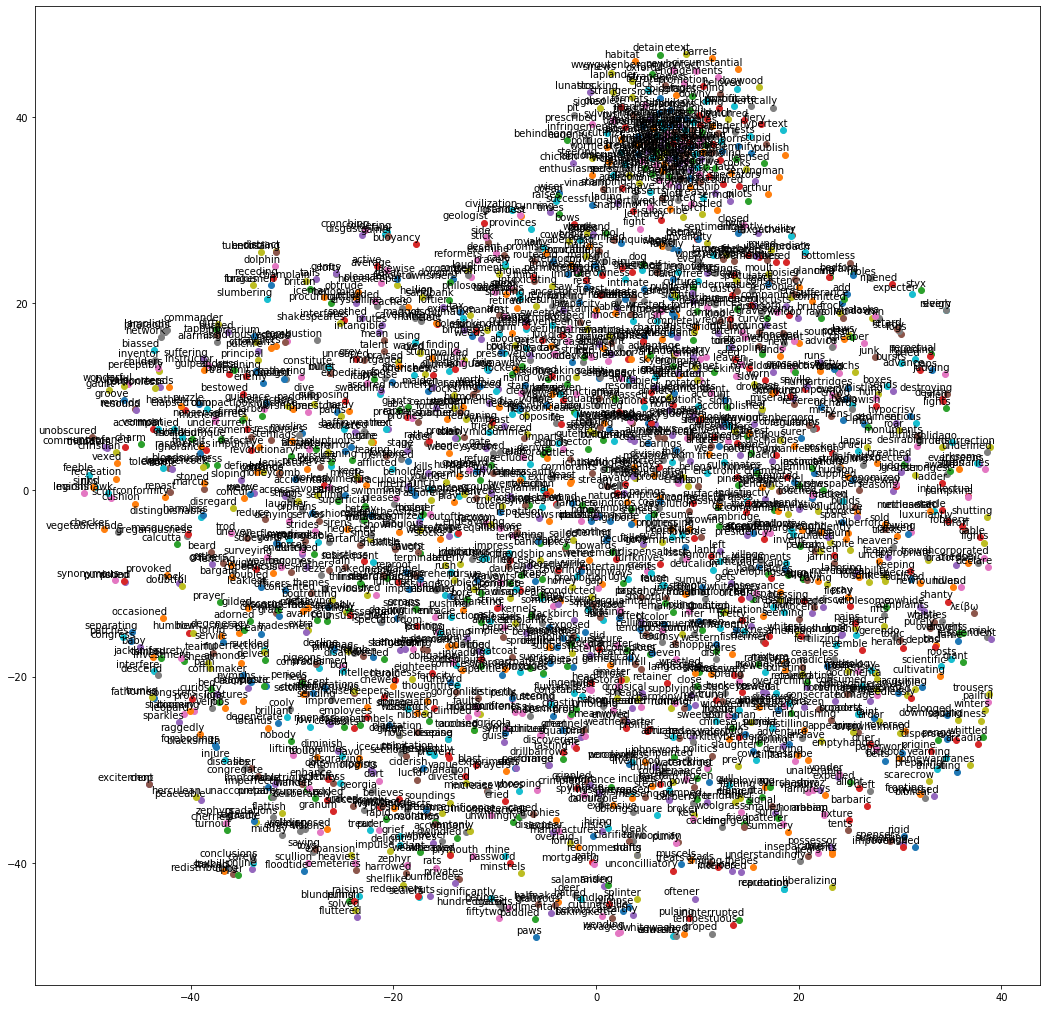

In [730]:
plot_with_labels(low_dim_embs, labels)

## Getting embedding for a subset of text

In [752]:
words = np.load('GDM5_test800/word_list.npy')

In [771]:
def get_embedding(words, word_vector, K):
    X_dg4wv_list = []
    
    for word in words:
        if word in word_vector:
            emb = word_vector[word]
            X_dg4wv_list.append(emb)
            
    X_dg4wv = np.zeros([len(X_dg4wv_list), K])
    
    for i in range(len(X_dg4wv_list)):
        for j in range(len(X_dg4wv_list[i])):
            X_dg4wv[i][j] = X_dg4wv_list[i][j]
    
    return X_dg4wv

In [773]:
X_dg4wv = get_embedding(words, word_vector, K)

In [775]:
np.save('GDM5_test800/X_dg4wv.npy',X_dg4wv)

## Problem here!
## Now it would need to solve the quartic NLP 
## using the result provided by naive Barvinok as initial point
## but I think we can ignore it

In [468]:
def proximity(X, K, index):
    X = np.reshape(X, (int(len(X)/K) , K))
    sum = 0.0
    count = 0
    for edge in edges_sets[index]:
        sum += (np.linalg.norm(X[edge[0]] - X[edge[1]])**2 - b_list[index][count])**2
        print(index)
        count += 1
    return sum

In [469]:
def NLP_solver(X, K, index):
    sol = minimize(proximity, X0, args = (K, index), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    return sol.x

In [470]:
def get_sentences_realization(X_proj, K):
    sentences_realizations = []
    
    for i in range(len(X_proj)):
        start_time = time.time()
        realization = NLP_solver(X_proj[map_indices[i]], K, map_indices[i])
        print("--- %s seconds ---" % (time.time() - start_time))
        sentences_realizations.append(np.reshape(realization, (int(len(realization)/K), K)))
    
    return sentences_realizations